In [46]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

In [6]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [95]:
class ScenarioEnsemble:
    # get the median aggregate scenario ensemble for an individual model given a set of projections for >1 scenario
    # reported in quantile format.
    
    # this method takes the average of all quantiles to find one projection that is an ensemble of all scenarios.
    # performed for all projection locations reported in the given DataFrame
    
    # Input dataframe must have: location, scenario_id, target_end_date, target, value, type, and quantile columns
    
    def __init__(self, df, obsdf, target, incidence = True, max_date = False, start_week = False, end_week = False):
        self.df = df # input dataframe with all scenarios, locations, and quantiles
        self.obsdf = obsdf # input of surveillance data of interest
        self.target = target # target metric of interest (case, death, hospitalization)
        self.inc = incidence # True if incident measures, False if cumulative
        self.max_date = max_date # maximum date you want to analyze, cut off date
        self.start_week = start_week # beginning of observations of interest
        self.end_week = end_week # end of observations of interest
        self.locations = pd.DataFrame()
        self.scenario_ensemble = pd.DataFrame()
        
        
    def get_locations(self):
        # get df with US state names, populations, and abbreviations and corresponding numerical code 
        locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
        
        self.locations = locations
        
        
    def get_observations(self, target_location):
        # get and format surveillance data of interest
        observations = self.obsdf.copy()
        
        if self.target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = self.target
            
        # read in observations dataframe
        observations = self.obsdf.copy()
        observations['date'] = pd.to_datetime(observations['date'])

        #filter start - end week
        if self.start_week:
            observations = observations[(observations['date'] >= pd.to_datetime(self.start_week.startdate())) ]
            
        if self.end_week:
            observations = observations[(observations['date'] <= pd.to_datetime(self.end_week.enddate()))]
                                

        #filter location
        observations = observations[observations['location'] == target_location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        if self.max_date:
            observations = observations[observations['date'] <= max_date].copy()

        #transform to Observation object
        observations = Observations(observations)

        return observations
    

        
    def get_scenarioensemble(self):
        # calculate scenario ensemble for all locations with quantiles reported in the input df
        predictions = self.df
        
        loclist = list(predictions.location.unique())
        
        
        median_ensembles = pd.DataFrame()
        for l in loclist: # loop through all locations
            
            target_location = l
            
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            
            pred = predictions[predictions['location'] == target_location].copy()
                                               
            target_prediction_list = [f"{i} wk ahead {'inc' if self.inc else 'cum'} {self.target}" for \
                                      i in range(1,len(list(pred.target_end_date.unique()))+1)]
                ## might need to change if data in different format, this is for ensemble^2 rounds 5-16 
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if self.max_date:
                pred = pred[pred['target_end_date'] <= self.max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            # calculate scenario ensemble
            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], 
                                            t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            
            med_ensemble_predictions['location'] = target_location
            med_ensemble_predictions['target'] = self.target
                                               
            median_ensembles = pd.concat([median_ensembles, med_ensemble_predictions])
                                               
            predictions_list += [med_ensemble_predictions]
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Scenario ensemble"]

        self.scenario_ensemble = median_ensembles
        
        return median_ensembles
          

class Scoring(ScenarioEnsemble):
    # calculate score values for probabilistic epidemic forecasts 
    # find WIS, MAPE, and coverage over whole projection window as well as timestamped for every week.
    # uses scorepi package to calculate the scores 
    # score dataframe must have 'Model' column to differentiate and calculate scores for different models
    
    def __init__(self, df, obsdf, scoredf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, target, incidence, max_date, start_week, end_week)
        self.scoredf = scoredf #dataframe we want to use to calculate performance analysis/scoring
        
    def get_all_average_scores(self):
        predictions = self.scoredf.copy()
        #predictions = Predictions(predictions, t_col = 'target_end_date')
        
        allscore = {}
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique():
                
                if target_location in ['60','66','69', '72', '78']:
                    continue
                
                observations = self.get_observations(target_location)

                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date')

                d,_ = score_utils.all_scores_from_df(observations, pred, mismatched_allowed=False)

                allscore[model][target_location] = d
            
        
        return allscore
    
    def organize_average_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis_mean', and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        average_scores = pd.DataFrame()
        
        allscore = self.get_all_average_scores()
        
        for model in allscore.keys():
            scoresmod = allscore[model]
            for loc in scoresmod.keys():
                
                    
                scoresloc = scoresmod[loc]

                scoredict = {'Model': model ,'location': loc}
                for score in want_scores:
                    scoredict[score] = scoresloc[score]


                average_scores = pd.concat([average_scores, pd.DataFrame(scoredict, index=[0])])

        
        average_scores = average_scores.reset_index() 
        average_scores = average_scores.drop(columns=['index'])
        
        return average_scores
    
    def get_all_timestamped_scores(self):
        predictions = self.scoredf.copy()
        
        allscore = {}
        
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique():
                if target_location in ['60','66','69', '72', '78']:
                    continue
                    
                observations = self.get_observations(target_location)

                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date')

                allscore[model][target_location] = {}
                for t in pred.target_end_date.unique():
                    prednew = pred[pred.target_end_date == t]
                    obsnew = observations[observations.date == t]

                    obsnew = Observations(obsnew)
                    prednew = Predictions(prednew, t_col = 'target_end_date')

                    d = score_utils.all_timestamped_scores_from_df(obsnew, prednew)

                    allscore[model][target_location][t] = d

        #self.allavgscores = allscore
        
        return allscore
    
    def organize_timestamped_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis'
        
        time_scores = pd.DataFrame()
        
        allscore = self.get_all_timestamped_scores()
        
        for model in allscore.keys():
            scoremod = allscore[model]
        
            for loc in scoremod.keys():
                if loc in ['60','66','69', '72', '78']:
                    continue
                    
                scoresloc = scoremod[loc]

                for t in scoresloc.keys():
                    tdf = scoresloc[t]

                    scoredict = {'Model':model ,'location':loc, 'target_end_date':t}
                    for score in want_scores:
                        scoredict[score] = tdf[score]


                    time_scores = pd.concat([time_scores, pd.DataFrame(scoredict, index=[0])])

        
        time_scores = time_scores.reset_index() 
        time_scores = time_scores.drop(columns=['index'])
        
        return time_scores
    
    
    def get_rescaled_wis(self):
        # calculate WIS rescaled by standard deviation 
        # need to have WIS scores for multiple models
        
        time_scores = self.organize_timestamped_scores(['wis'])
        
        time_scores = time_scores[~time_scores['location'].isin(['60','66','69', '72', '78'])]
        
        wisstdev = pd.DataFrame()
        for loc in time_scores.location.unique():
            for date in time_scores.target_end_date.unique():
                df = time_scores[(time_scores.location == loc) & (time_scores.target_end_date == date)]
                
                stdev = df['wis'].std()
                
                df['wis_scaled'] = df['wis'] / stdev
                
                wisstdev = pd.concat([wisstdev, df])
                
        wisstdev = wisstdev.reset_index()
        wisstdev = wisstdev.drop(columns=['index'])
        
        return wisstdev
    
    
    def get_wis_ratios(self, numerator_model, denominator_model, timestamped=False):
        # need all models of interest in score df so we can calculate wis of each
        # input is numerator model and denominator model to calculate wis ratio
        # input whether you want ratio taken at each time point or over average of whole time window
        
        if timestamped == True:
            scores = self.organize_timestamped_scores(['wis'])
        else:
            scores = self.organize_average_scores(['wis_mean'])
            scores = scores.rename(columns={'wis_mean':'wis'})
            
        num = scores[scores.Model == numerator_model]
        num = num.rename(columns={"wis": "wis_num"})
        
        denom = scores[scores.Model == denominator_model]
        denom = denom.rename(columns={"wis": "wis_denom"})
        
        if timestamped == True:
            scoresmerge = pd.merge(num, denom, how='inner', on = ['location', 'target_end_date'])
        else:
            scoresmerge = pd.merge(num, denom, how='inner', on = ['location'])
            
        scoresmerge['wis_ratio'] = scoresmerge['wis_num'] / scoresmerge['wis_denom']
        
        return scoresmerge
        
    
    
class Plots(Scoring):
    # make plots related to performance analysis, scoring, WIS ratios, etc.
    # uses output from score functions so input must be data you want to be scored and plotted
    
    
    def __init__(self, df, obsdf, scoredf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, scoredf, target, incidence, max_date, start_week, end_week)
        
        
    def get_rescaledWIS_boxplot(self):
        # make plot that shows the distribution of rescaled WIS values for all models of interest
        
        df = self.get_rescaled_wis()
        
        df = df.rename(columns= {"wis_scaled":"values","Model":"group"})

        wisnormalldf = df
        
        models = list(wisnormalldf.group.unique())
        allmed = []
        for model in models:
            med = wisnormalldf[wisnormalldf['group']== model]['values'].median()
            allmed.append(med)

        a = zip(models, allmed)
        a=list(a)
        res = sorted(a, key = lambda x: x[1])
        modelorder = list(zip(*res))[0]

        wisnormalldf.group = wisnormalldf.group.astype("category")
        wisnormalldf.group = wisnormalldf.group.cat.set_categories(modelorder)
        wisnormalldf.sort_values(["group"])
        
        wisnormalldf = wisnormalldf[wisnormalldf['values'] >= 0]
        total_groups = wisnormalldf.group.unique().shape[0]
        total_min = 0 #data['values'].min()*-1.2
       # total_max = wisnormalldf['values'].max()*1.2

        fig, ax = plt.subplots(1,1,figsize = (10,8),tight_layout = False)
        
        i=0
        
        g = sns.boxplot(x='group', y='values', data=wisnormalldf,color = '#17B1BF',showfliers=False)

        for patch in ax.patches:
            r, gr, b, a = patch.get_facecolor()
            patch.set_facecolor((r, gr, b, .1))


        sns.swarmplot(x='group', y='values', data=wisnormalldf,color = "#49AFB7",alpha = .5,size=2, orient="v")    

        plt.ylim([0,np.quantile(wisnormalldf['values'], .95)]) # cuts off some outliers
        
        #g.set(ylabel=None)
        #g.set(yticklabels=[])
        #g.set(yticks=[])

        g.set(xlabel='')
        g.set(ylabel=r'Rescaled WIS value')

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)


        plt.show()

        
    def get_wisratio_plot(self,numerator_models, denominator_model, timestamped=False):
        # make plots that shows the distribution of WIS ratios for some numerator models all compared to a single
        # reference denominator model.
        
        allratios = pd.DataFrame()
        for model in numerator_models:
            df = self.get_wis_ratios(numerator_model=model, denominator_model=denominator_model,
                                timestamped=timestamped)
            
            allratios = pd.concat([allratios, df])
            
        fig = plt.figure(figsize=(7,len(numerator_models)*2.5))
        ax = fig.add_subplot(111)

        my_order = allratios.groupby(by=['Model_x'])['wis_ratio'].median().sort_values(ascending=True).index
        g = sns.boxplot(x='wis_ratio', y='Model_x', data=allratios,order=my_order, color = '#17B1BF',width=.4)


        plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)
        for patch in ax.patches:
            r, gr, b, a = patch.get_facecolor()
            patch.set_facecolor((r, gr, b, .1))


        sns.swarmplot(x='wis_ratio', y='Model_x', data=allratios,order=my_order,color = "#49AFB7",alpha = .35,size=3,
                      orient="h")    

        g.set(ylabel=None)
        g.set(yticklabels=[])
        g.set(yticks=[])

        g.set(xlabel='WIS ratio')

        #plt.xlim([0,5]) # cuts off some outliers

        a = 0
        for mod in list(my_order):
            plt.text(0.01,a-.25, mod, fontsize=10, style='italic', color='dimgray')
            a+=1

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)



        #plt.suptitle(r'Rescaled WIS values for Death Predictions, all Rounds and Locations', fontsize=14)
        plt.tight_layout()
       #plt.savefig('ensemblecomp_WISvals_rd17.pdf')
        plt.show()
        
        
        
    def get_coverage_plot(self):
        # make plot that shows average coverage for a model for different prediction intervals
        
        fig, ax = plt.subplots(1,1,figsize = (8,6),tight_layout = False)
        
        
        covers = [10,20,30,40,50,60,70,80,90,95,98]
        covsy = [cv/100 for cv in covers]
        
        df = self.organize_average_scores(want_scores=['10_cov', '20_cov', '30_cov', '40_cov', '50_cov',
                                                      '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov'])
        
        
        dfgroup = df.groupby(['Model'], as_index=False).mean()
        
        N = len(dfgroup.Model.unique())
        
        cmap = plt.get_cmap('Set2', N)
        custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
        
        i=0
        for model in dfgroup.Model.unique():
            dfplot = dfgroup[dfgroup.Model == model]
            
            covs = list(dfplot[['10_cov', '20_cov', '30_cov', '40_cov', '50_cov','60_cov', '70_cov', '80_cov', 
                         '90_cov', '95_cov', '98_cov']].values[0])
        
            # if looping over multiple rounds and things with different observation lengths, would need to average
            # over these so rounds are all weighted the same
            
            plt.plot(covers, covs, '-o',color=custom_palette[i], label = model)
            
            i += 1
            
        plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 
        
        plt.xlabel('Prediction Interval', fontsize=14)
        plt.ylabel('Coverage', fontsize=14)

        plt.legend(fontsize=12)
        
        plt.show()


            
            
            

In [7]:
df = pd.read_parquet(f'./dat/Ensemble_rd12.pq')
df

,scenario_id,scenario_name,target,target_end_date,location,value,type,quantile,model_projection_date
0,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,01,1.041686e+06,quantile,0.01,2022-01-09
1,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,02,1.764332e+05,quantile,0.01,2022-01-09
2,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,04,1.550991e+06,quantile,0.01,2022-01-09
3,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,05,6.631201e+05,quantile,0.01,2022-01-09
4,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,06,6.453597e+06,quantile,0.01,2022-01-09
...,...,...,...,...,...,...,...,...,...
377563,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,66,0.000000e+00,quantile,0.99,2022-01-09
377564,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,69,0.000000e+00,quantile,0.99,2022-01-09
377565,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,72,1.183000e+02,quantile,0.99,2022-01-09
377566,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,78,5.950000e+01,quantile,0.99,2022-01-09


In [57]:
incidence = True
target_obs = 'hospitalization'
obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()
for model in ['Ensemble', 'Ensemble_LOP', "MOBS_NEU-GLEAM_COVID", "JHU_IDD-CovidSP"]:
    df = pd.read_parquet(f'./dat/{model}_rd12.pq')
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                            start_week = Week(2022,2), end_week = Week(2022, 13))
    medens = test.get_scenarioensemble()
    medens['Model'] = model

    dfall = pd.concat([dfall, medens])



In [61]:
dfall

,target_end_date,type,quantile,value,location,target,Model
0,2022-01-15,quantile,0.010,812.861394,01,hosp,Ensemble
1,2022-01-15,quantile,0.990,3400.335449,01,hosp,Ensemble
2,2022-01-15,quantile,0.975,3327.432758,01,hosp,Ensemble
3,2022-01-15,quantile,0.950,3244.610454,01,hosp,Ensemble
4,2022-01-15,quantile,0.900,3049.220958,01,hosp,Ensemble
...,...,...,...,...,...,...,...
283,2022-04-02,quantile,0.010,0.000601,56,hosp,JHU_IDD-CovidSP
284,2022-04-02,point,NaN,2.147030,56,hosp,JHU_IDD-CovidSP
285,2022-04-02,quantile,0.975,87.891990,56,hosp,JHU_IDD-CovidSP
286,2022-04-02,quantile,0.400,0.833122,56,hosp,JHU_IDD-CovidSP


In [20]:
test2 = Scoring(df=df, obsdf=obsdf,scoredf = dfall, 
               target='death', incidence = True, max_date = False, 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
d = test2.organize_average_scores(want_scores=['10_cov', '20_cov', '30_cov'])

In [21]:
d

,Model,location,10_cov,20_cov,30_cov
0,Ensemble,01,0.000000,0.000000,0.000000
1,Ensemble,02,0.000000,0.000000,0.083333
2,Ensemble,04,0.000000,0.000000,0.000000
3,Ensemble,05,0.000000,0.000000,0.083333
4,Ensemble,06,0.083333,0.083333,0.083333
...,...,...,...,...,...
213,JHU_IDD-CovidSP,50,0.000000,0.000000,0.083333
214,JHU_IDD-CovidSP,53,0.083333,0.250000,0.333333
215,JHU_IDD-CovidSP,55,0.083333,0.083333,0.166667
216,JHU_IDD-CovidSP,54,0.000000,0.166667,0.250000


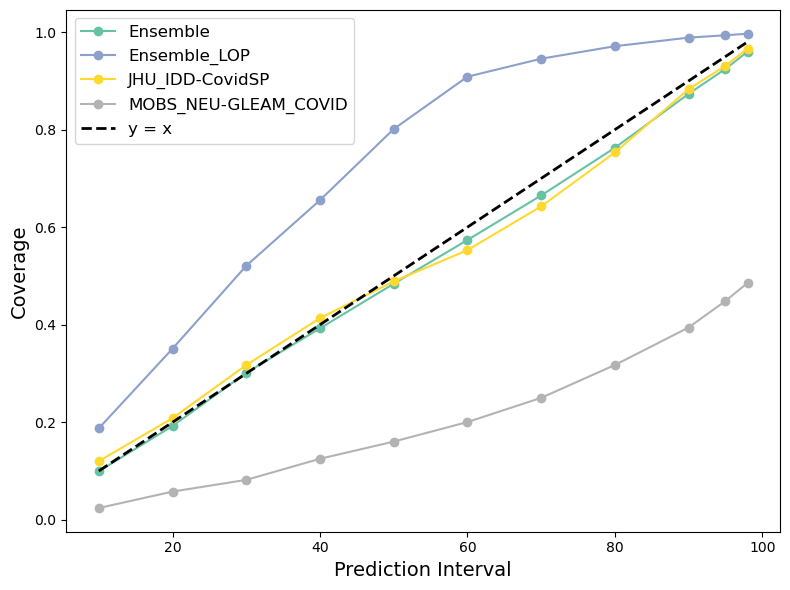

In [96]:
test2 = Plots(df=df, obsdf=obsdf,scoredf = dfall, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
test2.get_coverage_plot()
